In [16]:
import sys
sys.path.append('../') 

import MetaTrader5 as mt5
import pytz
import numpy as np

from datetime import datetime
from terminal.Extensions.Mt5Helper import Mt5Helper

In [17]:
mt5.initialize()

True

In [18]:
from_date = datetime(2024, 5, 17, tzinfo=pytz.utc)
to_date = datetime(from_date.year, from_date.month, from_date.day, 23, 59, 59, 0, tzinfo=pytz.utc)

In [19]:
data = mt5.copy_ticks_range('WINM24', from_date, to_date, mt5.COPY_TICKS_TRADE)

array([<Axes: xlabel='time_msc'>, <Axes: xlabel='time_msc'>], dtype=object)

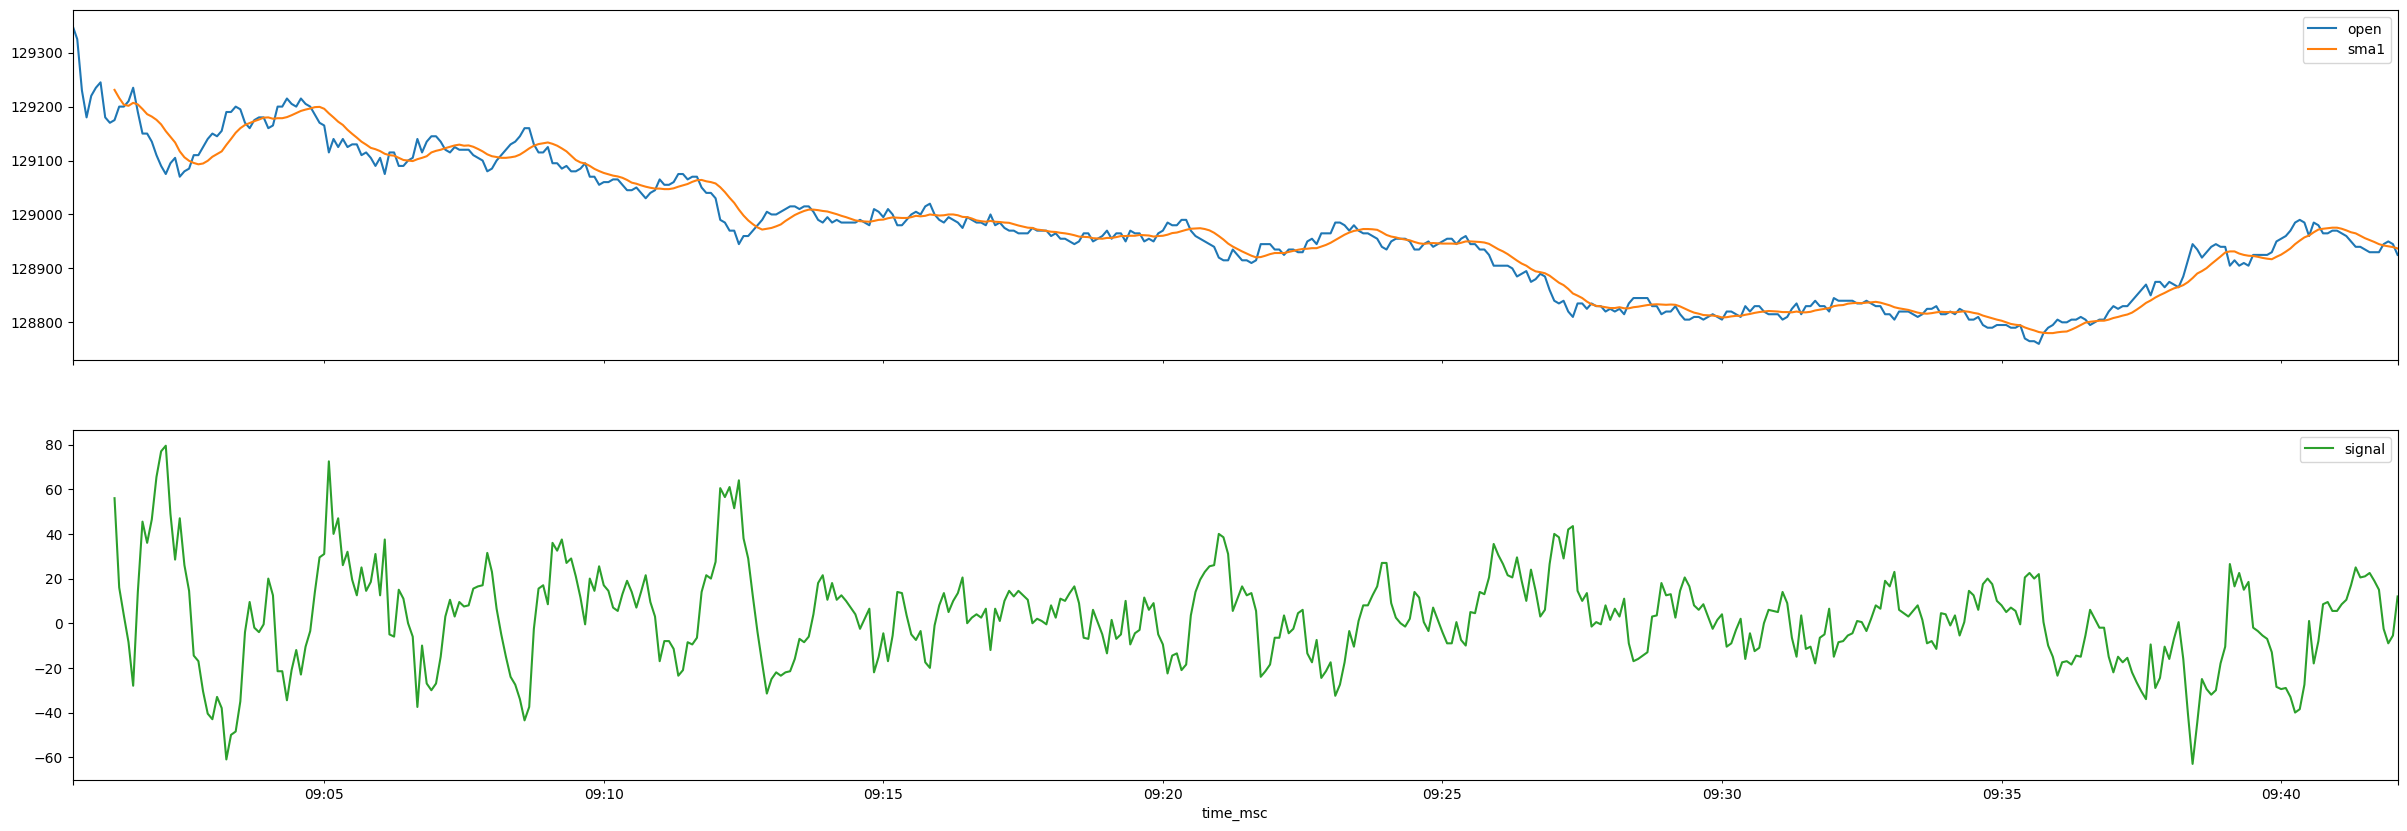

In [20]:
rates = Mt5Helper.OHLC(data, '5s')
rates.index = rates.index.tz_localize(None)
rates['sma1'] = rates['open'].rolling(10).mean()
rates['signal'] = rates['sma1'] - rates['open']
rates.iloc[0:500][['open', 'sma1', 'signal']].plot(
    kind="line", 
    subplots=[('open', 'sma1'), ('signal',)], 
    figsize=(30,10))

In [27]:

rates["sum_position"] = 0
rates["sum_position_quantity"] = 0
rates["average_price"] = 0
rates["open_profit"] = 0
rates["close_profit"] = 0
rates["profit"] = 0

sum_position = 0
sum_position_quantity = 0
average_price = 0
open_profit = 0
close_profit = 0
profit = 0
slippage = 0


def update(i):
    rates.loc[i, "sum_position"] = sum_position
    rates.loc[i, "sum_position_quantity"] = sum_position_quantity
    rates.loc[i, "average_price"] = average_price
    rates.loc[i, "open_profit"] = open_profit
    rates.loc[i, "close_profit"] = close_profit
    rates.loc[i, "profit"] = profit


for i, item in rates.iterrows():
    if np.isnan(item.open) or np.isnan(item.signal):
        update(i)
        continue

    buy = item.signal > 0

    open_profit = (
        0
        if sum_position_quantity == 0
        else (
            (item.open - average_price) * abs(sum_position_quantity)
            if sum_position_quantity > 0
            else (average_price - item.open) * abs(sum_position_quantity)
        )
    )
    close_profit = 0
    
    # posição comprada, sinal de venda
    if sum_position_quantity > 0 and open_profit > 100:
        average_price = sum_position / abs(sum_position_quantity)
        close_profit = (item.open - slippage - average_price) * abs(
            sum_position_quantity
        )
        profit += close_profit
        sum_position = 0
        sum_position_quantity = 0

    # posição vendida, sinal de compra
    elif sum_position_quantity < 0 and open_profit > 100:
        average_price = sum_position / abs(sum_position_quantity)
        close_profit = (average_price - item.open + slippage) * abs(
            sum_position_quantity
        )
        profit += close_profit
        sum_position = 0
        sum_position_quantity = 0

    # sinal de compra
    elif buy:
        sum_position += item.open + slippage
        sum_position_quantity += 1

    # sinal de venda
    elif not buy:
        sum_position += item.open - slippage
        sum_position_quantity -= 1

    average_price = (
        0 if sum_position_quantity == 0 else sum_position / abs(sum_position_quantity)
    )

    update(i)

rates.to_excel("output.xlsx")
rates


,open,high,low,close,tick_volume,real_volume,sma1,signal,sum_position,sum_position_quantity,average_price,open_profit,close_profit,profit
time_msc,,,,,,,,,,,,,,
2024-05-17 09:00:30,129350.0,129360.0,129325.0,129350.0,1494,8302,NaN,NaN,0,0,0,0,0,0
2024-05-17 09:00:35,129325.0,129375.0,129080.0,129235.0,5963,20319,NaN,NaN,0,0,0,0,0,0
2024-05-17 09:00:40,129230.0,129280.0,129150.0,129185.0,3354,10394,NaN,NaN,0,0,0,0,0,0
2024-05-17 09:00:45,129180.0,129270.0,129175.0,129220.0,3396,10848,NaN,NaN,0,0,0,0,0,0
2024-05-17 09:00:50,129220.0,129280.0,129220.0,129240.0,1844,5185,NaN,NaN,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-17 18:31:00,NaN,NaN,NaN,NaN,0,0,NaN,NaN,129175,1,129175,-75,0,0
2024-05-17 18:31:05,NaN,NaN,NaN,NaN,0,0,NaN,NaN,129175,1,129175,-75,0,0
2024-05-17 18:31:10,NaN,NaN,NaN,NaN,0,0,NaN,NaN,129175,1,129175,-75,0,0
